<a href="https://colab.research.google.com/github/VegemiteEnjoyer/Lecture_data_driven_science/blob/main/Lesson3_Answer_ESLiR_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Importing libraries for machine learning
## 機械学習用のライブラリのインポート
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
## Load data
## データの読み込み
datapath = '/content/drive/MyDrive/Colab Notebooks/boston.csv'
#./dataset/boston.csv'
df = pd.read_csv(datapath)

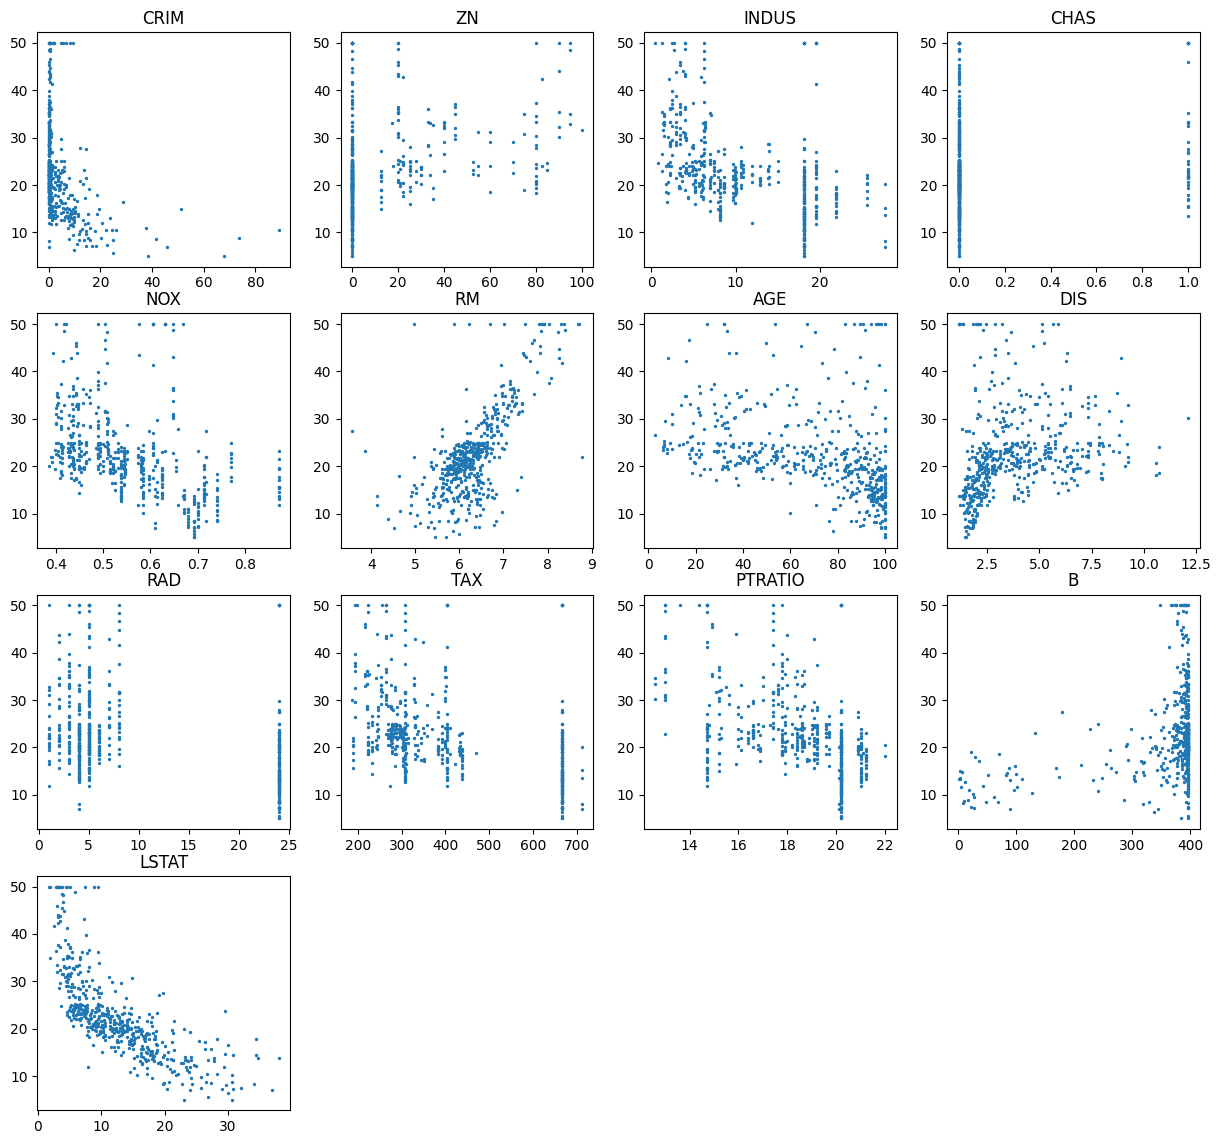

In [ ]:
## Q1 Display and illustrate the loaded data set (df).
## 問1 読み込んだデータセット(df)を表示、図示してください。

## Display input data
## 入力データの表示
df.head()
## title = df.iloc[:, 0]
## df.set_index(title)

fig = plt.figure(figsize=(15, 14))

y = df['target'].values
for i in range(len(df.columns)-1):
    x = df.iloc[:, i]
    ax = fig.add_subplot(4, 4, i+1)
    ax.scatter(x, y, s=2)
    ax.set_title(df.columns[i])

del fig,i,x, y, ax

In [ ]:
## data_X: row specification of explanatory variable, data_Y: row specification of objective variable
## data_X:説明変数の行の指定、data_Y:目的変数の行の指定
data_X = df.drop(columns='target').values #df.iloc[:,1:11].values
data_Y = df['target'].values #df.iloc[:,11].values/100 # convert to probablity

## Q2 Please standardize on X in the data you read.
## 問２ 読み込んだデータのうち、Xについて標準化してください。

sc = StandardScaler()
x_c = sc.fit_transform(data_X)

del sc

In [ ]:
n_features = data_X.shape[1]# number of feautures

In [ ]:
########## Preparing for Exhaustive search (Exact sparse modeling) ##########
def _generate_indicator(n_features):
    """
    Parameters
    ----------
    n_features : int
        特徴量の数

    Returns
    -------
    indicators : ndarray, shape = [n_comb, n_features (+ 1)]
        Indicator vector
    """
    n_comb = 2 ** n_features
    indicators = [
        _transform_indicator(i, n_features) for i in range(n_comb)
    ]
    indicators = np.array(indicators, dtype=int)
    return indicators

def _remove_null_indicator(indicators):
    """
    fit_interceptがfalseの時に，特徴量を何も用いない
    予測モデルを除く

    Parameters
    ----------
    indicators : ndarray, shape = [n_indicator, n_features]

    Returns
    -------
    filtered_indicators : ndarray, shape = [n_indicator-1, n_features]
    """
    index = np.arange(indicators.shape[0])
    filtered = index[(indicators == 1).sum(axis=1) > 0]
    return indicators[filtered, :]

def _transform_indicator(i, max_length=None):
    """
    整数を二進数にし，Indicator vectorを生成

    Parameters
    ----------
    i : int
        Indicator vectorに変換する整数

    max_length : int
        Indicator vectorの長さ, 特徴量の数に対応
        条件 : len(bin(i)[2:]) <= max_length

    Returns
    -------
    indictor : list, shape = [len(bin(i)[2:]) or length]

    ex) reverseされる点に注意
    transform_indicator(6, None)
        6 ---> [0, 1, 1]
    transform_indicator(6, 5)
        6 ---> [0, 1, 1, 0, 0]
    """
    b = bin(i)[2:]
    indicator = list(map(int, list(b)))
    if max_length is not None:
        indicator = [0] * (max_length - len(indicator)) + indicator
    return indicator[::-1]

def _remove_null_indicator(indicators):
    """
    fit_interceptがfalseの時に，特徴量を何も用いない
    予測モデルを除く

    Parameters
    ----------
    indicators : ndarray, shape = [n_indicator, n_features]

    Returns
    -------
    filtered_indicators : ndarray, shape = [n_indicator-1, n_features]
    """
    index = np.arange(indicators.shape[0])
    filtered = index[(indicators == 1).sum(axis=1) > 0]
    return indicators[filtered, :]

In [ ]:
## Derive all indicator combinations
## すべてのindicatorの組み合わせを導出
indicators_ = _generate_indicator(n_features)
indicators_ = _remove_null_indicator(indicators_) #Excluding predictive models that use no features

## Evaluate performance with K-split cross validation (n_splits can be changed arbitrarily)
## K分割交差検証（cross validation）で性能を評価する(分割数n_splitsは任意に変更)
skf = KFold(n_splits=10, shuffle =True, random_state = 0)

## Q3 Introduce a linear regression model with intercept.
## Q3-Option * What would happen if you changed to a linear regression model without an intercept?
## Please consider this after you have completed the derivation in one step.
## 問３ 切片のある線形回帰モデルを導入してください。
## 問3-オプション　* 切片のない線形回帰モデルに変更した場合どうなるでしょうか？一通り導出が終わった後に、検討してみてください。
lr_reg = linear_model.LinearRegression(fit_intercept=True)


In [ ]:
## Q4 Print the combination of features (indicators_) to be used.
## 問4 使用する特徴量の組み合わせ(indicators_)をプリントしてみてください。 ##########
print(indicators_)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [ ]:
## Exhaustive search for sparse modeling
## 全状態探索
scores = {"mean": [], "std": []}
list_scores = []
list_intercept = []
list_coef = []

for i, ind in enumerate(indicators_):
    ## print(ind)
    ind_bool = ind == 1

    ## evaluate each model by Cross validation ##########
    this_scores =[]
    for train_index, test_index in skf.split(x_c, data_Y):
        #Test and Training data
        X_train = x_c[train_index, :]
        X_train = X_train[:,ind_bool]
        X_test  = x_c[test_index, :]
        X_test  = X_test[:,ind_bool]
        y_train, y_test = data_Y[train_index], data_Y[test_index]

        ## Q5 Construct a linear regression model and make predictions.
        ## Specify the model to be fitted:
        ## 問5 線形回帰モデルの構築と、予測を行ってください。
        ## fitさせるモデルの指定##########
        lr_result = lr_reg.fit(X_train, y_train)

        ## ##predict
        pred = lr_result.predict(X_test)
        score = (mean_squared_error(y_test, pred))
        this_scores.append(score)

    ## Get coef
    lr_result = lr_reg.fit(x_c[:, ind_bool], data_Y)

    this_coef = np.zeros(ind_bool.shape)
    this_coef[ind_bool] = lr_result.coef_
    list_coef.append(this_coef)

    list_intercept.append(lr_result.intercept_)

    ## CVE
    list_scores.append(np.mean(this_scores))
    ## print('CVE: %.4f' % list_scores[i])
    ## print(list_weight[i])

del X_test, X_train, y_test, y_train, pred, this_scores, score, lr_result,
del i, ind_bool, train_index, test_index

In [ ]:
## Sort by decreasing CVE value
## CVE値の小さい順に並べ替え
sorted_list_scores = np.sort(list_scores)
sorted_index = np.argsort(list_scores)
sorted_list_ind = []
sorted_list_coef = []
sorted_list_intercept = []

for i in sorted_index:
    sorted_list_ind.append(indicators_[i])
    sorted_list_coef.append(list_coef[i])
    sorted_list_intercept.append(list_intercept[i])

In [ ]:
## Plotting program for weight diagrams
##ウェイトダイアグラムのプロットプログラム

#import numpy as np
#from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def weightdiagram_plot(data, mask):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_facecolor("black")
    # cmap_list = [
    #     [0, "blue"],
    #     [0.4, "lime"],
    #     [0.5, "yellow"],
    #     [0.6, "orange"],
    #     [1, "red"],
    # ]
    # cmap = LinearSegmentedColormap.from_list("mycmap", cmap_list)
    cmap='coolwarm'
    absmax = np.max(np.abs(data))
    vmin, vmax = -absmax, absmax
    mask_data = np.ma.array(data, mask=mask)
    mesh = ax.pcolormesh(mask_data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel("X axis")
    ax.set_title("Title")
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label("coef")
    plt.show()

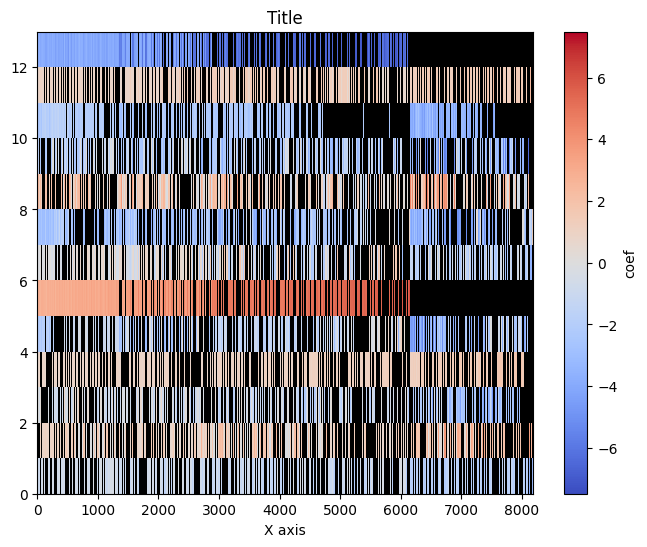

In [ ]:
## Plotting weight diagrams
sorted_list_ind_np = np.array(sorted_list_ind) ## np arrayへの変換
sorted_list_coef_np = np.array(sorted_list_coef) ## np arra
weightdiagram_plot(sorted_list_coef_np.T, np.ones_like(sorted_list_ind_np.T) - sorted_list_ind_np.T)
#/ The second argument is subtracted by np.ones_like to enter "0" for those selected as indexes.
#/ 二番目の引数は、インデックスとして選ばれているものは"0"として入力するため、np.ones_likeで引いている。

## Q6- Change the weight diagram program to create weight diagrams for the top 100 and 1000 CVEs.
## Q6-optional Try to create a weight diagram for a different regression model.
## 問6 ウェイトダイアグラムのプログラムを変更して、CVEのトップ100, 1000についてのウェイトダイアグラムを作成してください。
## 問6-オプション 回帰モデルを変えた時の、ウェイトダイアグラムの作成に挑戦してみてください。

In [ ]:
## output
np.savetxt('sorted_list_intercept.csv', np.array(sorted_list_intercept), delimiter=',')
np.savetxt('sorted_list_coef.csv', sorted_list_coef_np, delimiter=',')
np.savetxt('sorted_list_CVE.csv', np.array(sorted_list_scores), delimiter=',')